In [1]:
from MonteCarlo import GeometricBrownianMotion, CallOption
from Pricing import CallPrice
import numpy as np

In [9]:
#Parameters
r = 0.4
d = 0.1
T = 10
vol = 0.5
N_T = 10000
S_0 = 5
seed = 1
n_final_values = 100000

In [10]:
gbm = GeometricBrownianMotion(r=r, d=d, T = T, vol = vol, N_T= N_T, S_0 = S_0, seed = seed)
final_values = gbm.final_values(n=n_final_values)

In [11]:
K = 4
option = CallOption(K = K)
mc_price = gbm.monte_carlo_price(final_values=final_values, option = option)
exact_price = CallPrice(r=r, d=d, T = T, vol = vol,K=K, S = S_0)
print(f'Exact price = {exact_price}, Estimated price = {mc_price}')

Exact price = 1.7696089579814334, Estimated price = 1.7478645936436676


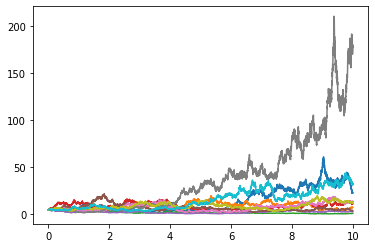

In [12]:
gbm.plot_paths(n=10, method='euler')